In [16]:
import argparse as ap
from collections import namedtuple
import csv
from enum import Enum
import jax as jax
import jax.numpy as np
import math as math
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import pickle as pl
import random as rand
import time as time

In [30]:
input_mol = "ethane"
input_ticks = 1000000000
dt = 1e-18
energyHistory = pd.read_csv(input_mol + '_energyHistory.csv')
bondHistory = pd.read_csv(input_mol + '_bondLengthHistory.csv')
dataLen = energyHistory["time"].count()
dataLen

500000

In [35]:
def draw_energy(energyHistory, input_mol, input_ticks, dt, q_start, q_end, out_file = None, title_suffix = ""):
    dataLen = energyHistory["time"].count()
    font = {'family' : 'DejaVu Sans',
        'size' : min(max(12, dataLen / 300 * (q_end - q_start) / 4), 24)}

    rng = range(int(q_start * dataLen / 4), int(q_end * dataLen / 4))

    plt.figure(figsize = (min(max(10, dataLen / 100 * (q_end - q_start) / 4), 25), 5))
    plt.rc('font', **font)
    plt.plot(energyHistory["time"][rng], energyHistory["potentialE"][rng], label = 'Potential') #, s = 2.5)
    plt.plot(energyHistory["time"][rng], energyHistory["kineticE"][rng], label = 'Kinetic') #, s = 2.5)
    plt.plot(energyHistory["time"][rng], energyHistory["potentialE"][rng] + energyHistory["kineticE"][rng], label = 'Total') #, s = 2.5)

    plt.xlim([energyHistory["time"][rng].min(), energyHistory["time"][rng].max()])

    # plt.title(input_mol.capitalize() + " Energy for " + str(input_ticks) + " Ticks" + title_suffix + ", dt = " + str(dt) + "s")
    #plt.title(input_mol.capitalize() + " Energy for " + str(input_ticks) + " Ticks" + title_suffix + ", dt = " + str(dt) + "s")
    plt.xlabel('Time (ps)')
    plt.ylabel('Energy (zJ)')
    plt.ylim(bottom=0)
    plt.legend(prop = {'size' : min(max(12, dataLen / 400 * (q_end - q_start) / 4), 12)}, markerscale = 5)
    plt.tight_layout()

    if out_file is None:
        plt.figure()
    else:
        plt.savefig(out_file)

In [36]:
def draw_bond(bondHistory, input_mol, input_ticks, dt, q_start, q_end, out_file = None, title_suffix = ""):
    dataLen = bondHistory["time"].count()
    font = {'family' : 'DejaVu Sans',
        'size' : min(max(12, dataLen / 750 * (q_end - q_start) / 4), 24)}

    rng = range(int(q_start * dataLen / 4), int(q_end * dataLen / 4))

    plt.figure(figsize = (min(max(10, dataLen / 400 * (q_end - q_start) / 4), 25), 5))
    plt.rc('font', **font)
    plt.plot([bondHistory["time"][int(q_start * dataLen / 4)], bondHistory["time"][int(q_end * dataLen / 4) - 1]], [1.455, 1.455], color = 'blue', linestyle = ':')
    plt.plot([bondHistory["time"][int(q_start * dataLen / 4)], bondHistory["time"][int(q_end * dataLen / 4) - 1]], [1.099, 1.099], color = 'orange', linestyle = ':')

    plt.plot(bondHistory["time"][rng], bondHistory["CC_Bonds"][rng], label = 'Average CC Bond Length') #, s = 2.5)
    plt.plot(bondHistory["time"][rng], bondHistory["CH_Bonds"][rng], label = 'Average CH Bond Length') #, s = 2.5)

    plt.xlim([energyHistory["time"][rng].min(), bondHistory["time"][rng].max()])

    # plt.title("Average " + input_mol.capitalize() + " Bond Lengths for " + str(input_ticks) + " Ticks" + title_suffix + ", dt = " + str(dt) + "s")
    plt.xlabel('Time (ps)')
    plt.ylabel('Bond Length (Å)')
    plt.legend(prop = {'size' : min(max(12, dataLen / 1000 * (q_end - q_start) / 4), 12)}, markerscale = 5)
    plt.tight_layout()

    if out_file is None:
        plt.figure()
    else:
        plt.savefig(out_file)

In [39]:
def draw_bond_histogram(bondHistory, input_mol, input_ticks, dt, q_start, q_end, binWidth, out_file = None):
    dataLen = bondHistory["time"].count()
    font = {'family' : 'DejaVu Sans',
        'size' : 12}

    rng = range(int(q_start * dataLen / 4), int(q_end * dataLen / 4))

    plt.figure(figsize = (10, 5))
    plt.rc('font', **font)

    cc_bins = np.arange(min(bondHistory["CC_Bonds"][rng]), max(bondHistory["CC_Bonds"][rng]) + binWidth, binWidth)
    cc_hist = plt.hist(bondHistory["CC_Bonds"][rng], bins = cc_bins, label = 'Average CC Bond Length')

    ch_bins = np.arange(min(bondHistory["CH_Bonds"][rng]), max(bondHistory["CH_Bonds"][rng]) + binWidth, binWidth)
    ch_hist = plt.hist(bondHistory["CH_Bonds"][rng], bins = ch_bins, label = 'Average CH Bond Length')

    maxY = max(np.max(cc_hist[0]), np.max(ch_hist[0]))

    plt.plot([1.455, 1.455], [0, maxY * 1.25], color = 'blue', linestyle = ':')
    plt.plot([1.099, 1.099], [0, maxY * 1.25], color = 'orange', linestyle = ':')

    # plt.title("Histogram of Average " + input_mol.capitalize() + " Bond Lengths Over Time for " + str(input_ticks) + " Ticks, dt = " + str(dt) + "s")
    plt.xlabel('Bond Length (Å)')
    plt.ylabel('Counts')
    plt.legend(prop = {'size' : 12})
    plt.tight_layout()

    if out_file is None:
        plt.figure()
    else:
        plt.savefig(out_file)

In [49]:
def draw_bond_histogram_overlay(bondHistory, input_mol, input_ticks, dt, q_start, q1_end, q2_end, binWidth, out_file = None):
    dataLen = bondHistory["time"].count()
    font = {'family' : 'DejaVu Sans',
        'size' : 12}

    rng1 = range(int(q_start * dataLen / 4), int(q1_end * dataLen / 4))
    rng2 = range(int(q_start * dataLen / 4), int(q2_end * dataLen / 4))

    plt.figure(figsize = (10, 5))
    plt.rc('font', **font)

    cc2_bins = np.arange(min(bondHistory["CC_Bonds"][rng2]), max(bondHistory["CC_Bonds"][rng2]) + binWidth, binWidth)
    cc2_hist = plt.hist(bondHistory["CC_Bonds"][rng2], bins = cc2_bins, label = 'Average CC Bond Length (1ps)', color = 'blue', alpha = 0.5)

    ch2_bins = np.arange(min(bondHistory["CH_Bonds"][rng2]), max(bondHistory["CH_Bonds"][rng2]) + binWidth, binWidth)
    ch2_hist = plt.hist(bondHistory["CH_Bonds"][rng2], bins = ch2_bins, label = 'Average CH Bond Length (1ps)', color = 'orange', alpha = 0.5)

    cc1_bins = np.arange(min(bondHistory["CC_Bonds"][rng1]), max(bondHistory["CC_Bonds"][rng1]) + binWidth, binWidth)
    cc1_hist = plt.hist(bondHistory["CC_Bonds"][rng1], bins = cc1_bins, label = 'Average CC Bond Length (3ps)', color = 'greem', alpha = 0.5)

    ch1_bins = np.arange(min(bondHistory["CH_Bonds"][rng1]), max(bondHistory["CH_Bonds"][rng1]) + binWidth, binWidth)
    ch1_hist = plt.hist(bondHistory["CH_Bonds"][rng1], bins = ch1_bins, label = 'Average CH Bond Length (3ps)', color = 'red', alpha = 0.5)

    maxY = max(max(np.max(cc1_hist[0]), np.max(ch1_hist[0])), max(np.max(cc2_hist[0]), np.max(ch2_hist[0])))

    plt.plot([1.455, 1.455], [0, maxY * 1.25], color = 'blue', linestyle = ':')
    plt.plot([1.099, 1.099], [0, maxY * 1.25], color = 'orange', linestyle = ':')

    # plt.title("Histogram of Average " + input_mol.capitalize() + " Bond Lengths Over Time for " + str(input_ticks) + " Ticks, dt = " + str(dt) + "s")
    plt.xlabel('Bond Length (Å)')
    plt.ylabel('Counts')
    plt.legend(prop = {'size' : 12})
    plt.tight_layout()

    if out_file is None:
        plt.figure()
    else:
        plt.savefig(out_file)

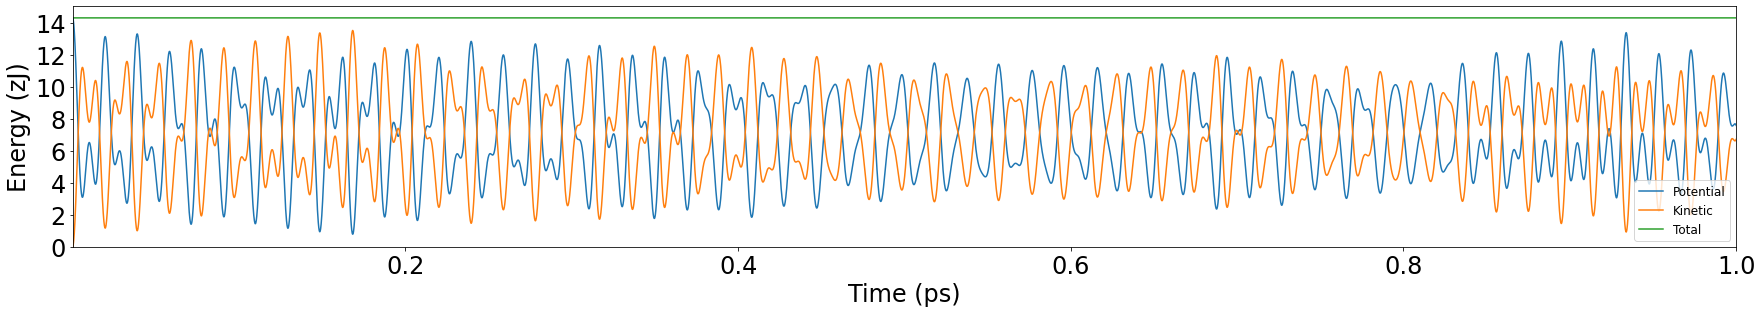

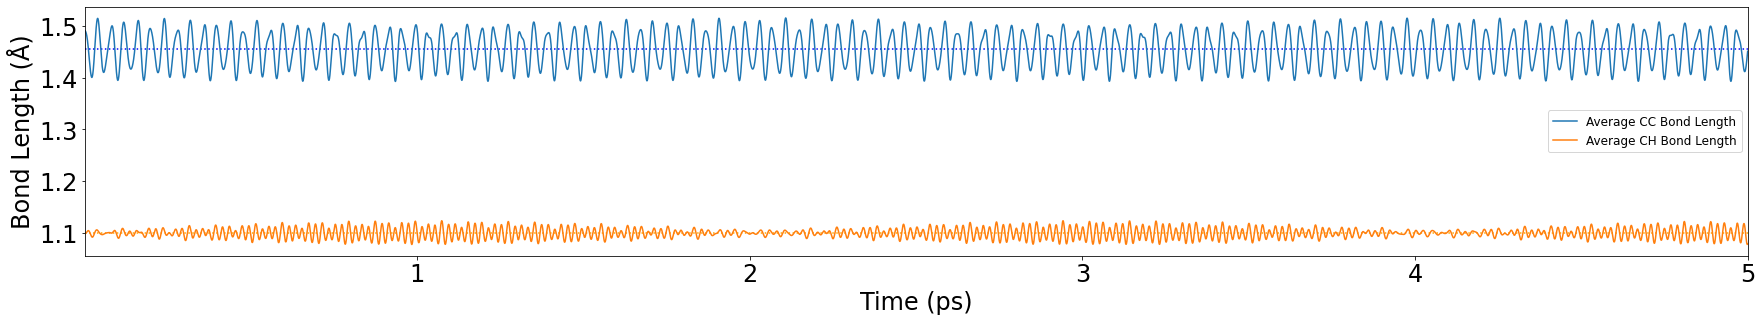

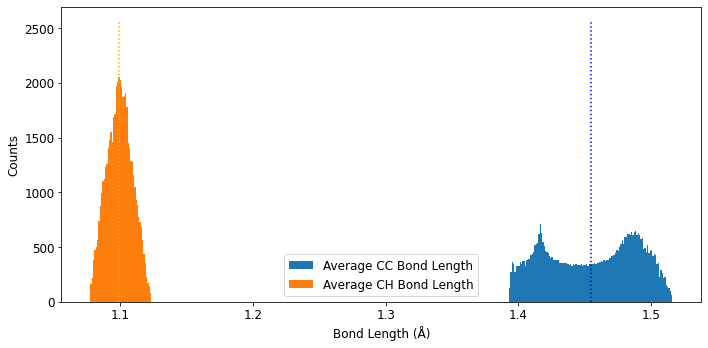

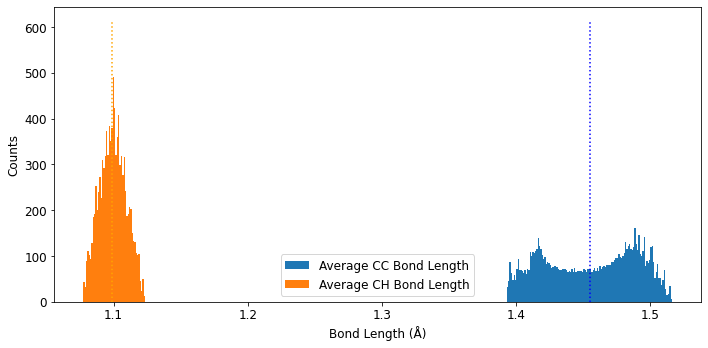

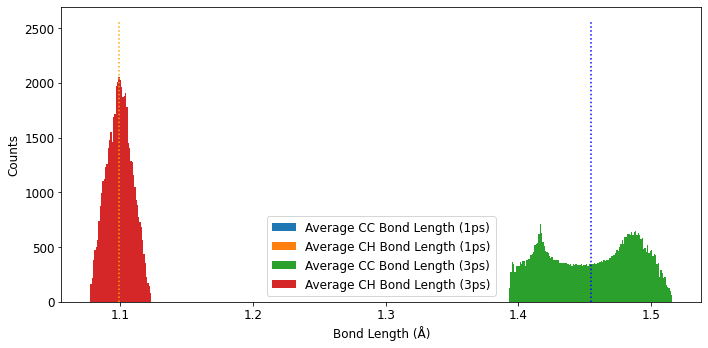

In [52]:
a = 0
b = 0.4
c = 0.08

draw_energy(energyHistory, input_mol, input_ticks, dt, a, c, input_mol + "_energyr05.png")
draw_bond(bondHistory, input_mol, input_ticks, dt, a, b, input_mol + "_bondr05.png")
draw_bond_histogram(bondHistory, input_mol, input_ticks, dt, a, b, 0.001, input_mol + "_bondHistr3ps05")
draw_bond_histogram(bondHistory, input_mol, input_ticks, dt, a, c, 0.001, input_mol + "_bondHistr1ps05")
draw_bond_histogram_overlay(bondHistory, input_mol, input_ticks, dt, a, b, c, 0.001, input_mol + "_bondHistr1ps05")